# Advanced Analytics

Under this framework it is also convenient to run more advanced analytics like supervised or unsupervised learning algorithms. Given currently there is only one dataset covering limited features, we will show a few straightforward examples of advanced techniques.


* <a href=#bookmark1>Bivariate Analysis</a>
* <a href=#bookmark2>K-Means Clustering: A Simple Example</a>

In [1]:
# Import necessary packages
import smv
import pandas as pd
from numpy import array
from pyspark.sql import HiveContext, DataFrame

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Read the input data from a csv file
raw = openCsv("data/input/employment/CB1200CZ11.csv")
raw_clean = raw.where((col("EMP_F").isNull())&(col("ST")!=99)).cache()

----
<a name='bookmark1'/>
## Bivariate Analysis

In [3]:
# Pearson correlation
raw_clean.select(
    (col("PAYANN")/col("EMP")).alias("PAYANN_per_EMP"),
    "ESTAB"
).corr("PAYANN_per_EMP", "ESTAB")

0.23626089869715505

----
<a name='bookmark2'/>
## K-Means Clustering: A Simple Example

Suppose we are interested to see which states are relatively similar in terms of average payroll per employee and # of establishments. What we can do is to run a clustering based on these features. One of the standard clustering algorithms is K-Means, which is supported in both the scikit-learn package in Python and ml package in PySpark.

Before running the clustering, we firstly create features that will be used to cluster states.

In [4]:
all_feature = raw_clean.groupBy("ST").agg(
    avg(col("PAYANN")/col("EMP")).alias("avg_PAYANN_per_EMP"),
    avg(col("ESTAB")).alias("avg_ESTAB")
).na.drop()

#### Scikit-Learn Package

In [5]:
from sklearn.cluster import KMeans

In [6]:
# format model input
feature_arrays = all_feature.drop("ST").toPandas().values

In [7]:
y_pred = KMeans(n_clusters=5).fit_predict(feature_arrays)

In [8]:
y_pred

array([2, 1, 3, 2, 4, 4, 4, 2, 3, 2, 0, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 2, 2,
       4, 4, 2, 3, 3, 1, 4, 4, 4, 4, 2, 3, 4, 3, 4, 3, 1, 2, 1, 4, 3, 4, 3,
       1, 2, 1, 3, 3], dtype=int32)

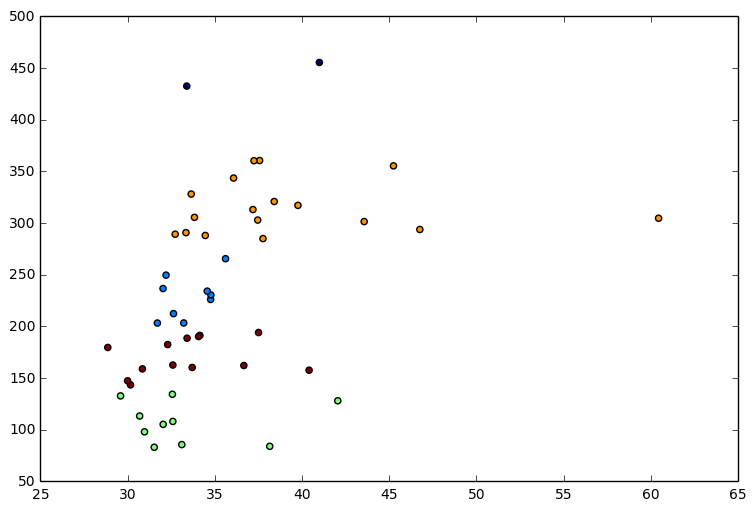

In [9]:
plt.figure(figsize=(9,6))
plt.scatter(feature_arrays[:,0], feature_arrays[:,1], c=y_pred)

#### PySpark ML

In [10]:
from pyspark.ml.clustering import KMeans as ml_kmeans
from pyspark.ml.feature import VectorAssembler

In [11]:
# Format input data: vectorize all features
feature_lst = ["avg_PAYANN_per_EMP", "avg_ESTAB"]
vecAssembler = VectorAssembler(inputCols=feature_lst, outputCol="features")
feature_sel = vecAssembler.transform(all_feature)

In [12]:
# Run clustering
ml_kmeans_def = ml_kmeans(k=5, seed=1)
model = ml_kmeans_def.fit(feature_sel)

In [13]:
# view centers of each cluster
model.clusterCenters()

[array([  38.42128174,  384.66958233]),
 array([  33.32884978,  107.26749735]),
 array([  32.83855282,  161.63474717]),
 array([  38.92734204,  300.46473298]),
 array([  33.75191146,  213.36928972])]

In [19]:
cluster = model.transform(feature_sel).cache()
cluster_pd = cluster.toPandas()

In [20]:
feat1 = cluster_pd["avg_PAYANN_per_EMP"].values.ravel()
feat2 = cluster_pd["avg_ESTAB"].values.ravel()
pred = cluster_pd["prediction"].values.ravel()

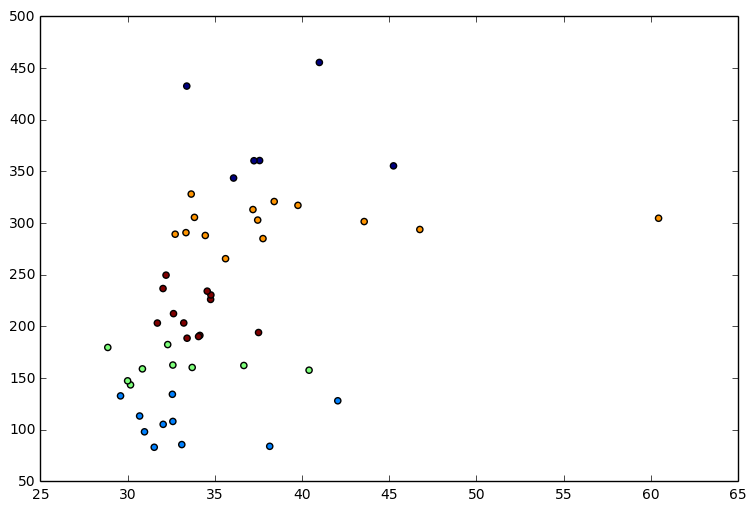

In [21]:
plt.figure(figsize=(9,6))
plt.scatter(feat1, feat2, c=pred)

We can further check the clusters and the states within each cluster

In [17]:
cluster_pd.sort_values(by='prediction').head(51)

,ST,avg_PAYANN_per_EMP,avg_ESTAB,prediction
45,44,37.246753,360.376623,0
36,34,45.247649,355.394984,0
34,32,36.076471,343.611765,0
15,12,33.391833,432.604692,0
10,06,40.995754,455.475584,0
13,10,37.569231,360.553846,0
0,50,33.106838,85.675214,1
47,46,30.968504,98.035433,1
40,38,38.149813,84.000000,1
33,31,30.689732,113.323661,1


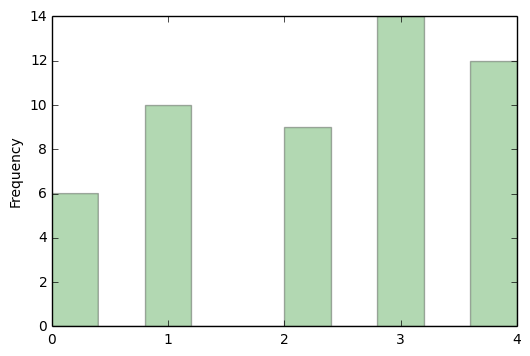

In [18]:
cluster_pd['prediction'].plot(kind='hist', xticks=[0,1,2,3,4], color='g', alpha=0.3)